# **E11. Detección de Anomalías con PyCaret**  

📌 **Objetivo**  
Usar PyOD (Python Outlier Detection) para probar múltiples algoritmos de detección de anomalías y compararlos en datos de consumo energético. 

## **1 Instalación y carga de datos**  
Si no tienes PyOD instalado, instálalo con:  

```bash
pip install pyod
```

A continuación, carga los datos:  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from sklearn.preprocessing import MinMaxScaler

# Cargar dataset
df = pd.read_csv("data/m4_datos_energia_edificio.csv", index_col=0)
df.index = pd.to_datetime(df.index)

# Agregamos datos a diario
df = df.groupby(df.index.date).sum()

# Ver las primeras filas
print(df.head())

            Energia Consumida  Temperatura  Humedad
2024-07-01             191.15       521.04  1842.37
2024-07-02             185.83       527.25  1761.32
2024-07-03             200.53       531.10  1754.35
2024-07-04             197.76       531.86  1823.16
2024-07-05             196.79       526.29  1826.94


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, 2024-07-01 to 2024-12-31
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Energia Consumida  184 non-null    float64
 1   Temperatura        184 non-null    float64
 2   Humedad            184 non-null    float64
dtypes: float64(3)
memory usage: 5.8+ KB


---

## **2 Preprocesamiento y Configuración de PyCaret**  

In [158]:
# Interpolar valores nulos
df.interpolate(inplace=True)

# Normalizar datos
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

📌 **Explicación**:  
  - Interpolamos para manejar valores nulos.
  - Normalizamos los datos para mejorar la detección de anomalías.

---

## **3 Seleccionar modelos de detección de anomalías**  

In [159]:
# Lista de modelos a evaluar
models = {
    "Isolation Forest": IForest(contamination=0.05),
    "One-Class SVM": OCSVM(),
    "KNN": KNN(contamination=0.05),
    "Autoencoder": AutoEncoder(hidden_neuron_list=[8, 4, 4, 8], epoch_num=50, batch_size=16, contamination=0.05)
}

# Diccionario para almacenar resultados
results = {}

for name, model in models.items():
    print(f"Entrenando {name}...")
    model.fit(df_scaled)
    predictions = model.predict(df_scaled)  # 1 = Anomalía, 0 = Normal
    results[name] = predictions


Entrenando Isolation Forest...
Entrenando One-Class SVM...
Entrenando KNN...
Entrenando Autoencoder...


Training: 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


📌 **Explicación**:  
 - Probamos cuatro modelos: Isolation Forest, One-Class SVM, KNN y Autoencoder.
 - Entrenamos cada modelo y almacenamos las predicciones (1=Anomalía, 0=Normal).

---

## **4 Comparativa resultados**  


Número de anomalías detectadas por modelo:
Isolation Forest    10
One-Class SVM       19
KNN                  7
Autoencoder         10
dtype: int64


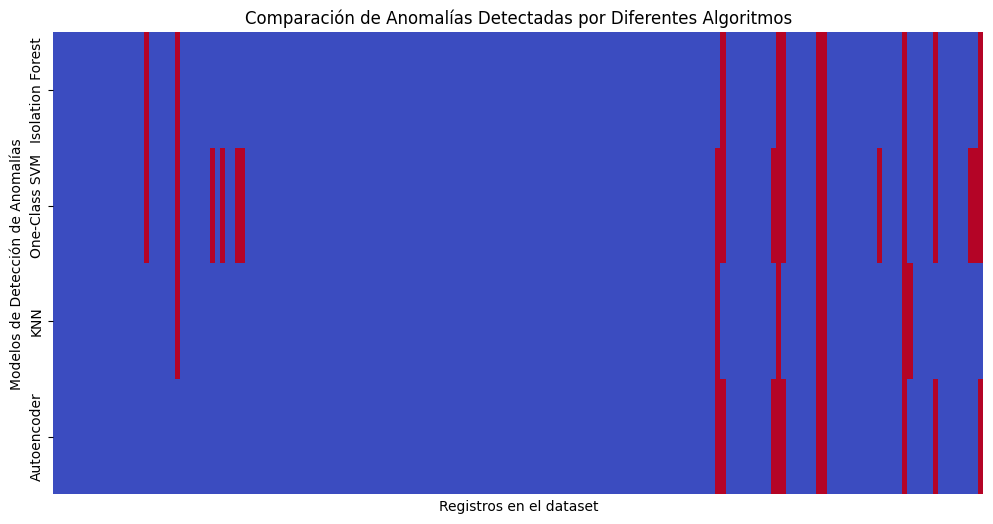

In [160]:
import seaborn as sns

# Convertir resultados en DataFrame
df_results = pd.DataFrame(results)
df_results["Real"] = df.index  # Usamos el índice temporal para facilitar la comparación

# Contar número de anomalías detectadas por cada modelo
anomaly_counts = df_results.drop(columns="Real").sum()
print("\nNúmero de anomalías detectadas por modelo:")
print(anomaly_counts)

# Visualización de anomalías detectadas por cada modelo
plt.figure(figsize=(12, 6))
sns.heatmap(df_results.drop(columns="Real").T, cmap="coolwarm", cbar=False, xticklabels=False)
plt.xlabel("Registros en el dataset")
plt.ylabel("Modelos de Detección de Anomalías")
plt.title("Comparación de Anomalías Detectadas por Diferentes Algoritmos")
plt.show()


📌 **Explicación**:  
 - Contamos cuántas anomalías detectó cada modelo.
 - Visualizamos las diferencias con un heatmap para ver patrones de detección.
---

## **5 Visualizamos resultados por modelo**  

In [161]:
df_results = df_results.set_index('Real')

In [165]:
plot_df = pd.concat([df_results, df['Energia Consumida']], axis=1)
plot_df.index = pd.to_datetime(plot_df.index)

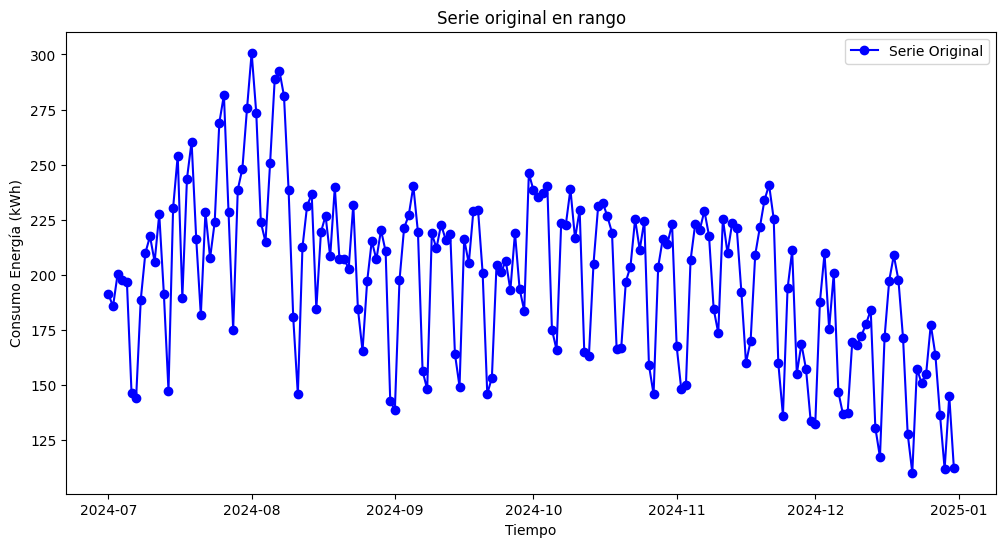

In [168]:
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df["Energia Consumida"], label="Serie Original", marker="o", color="blue")

plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía (kWh)")
plt.title("Serie original en rango")
plt.legend()
plt.show()

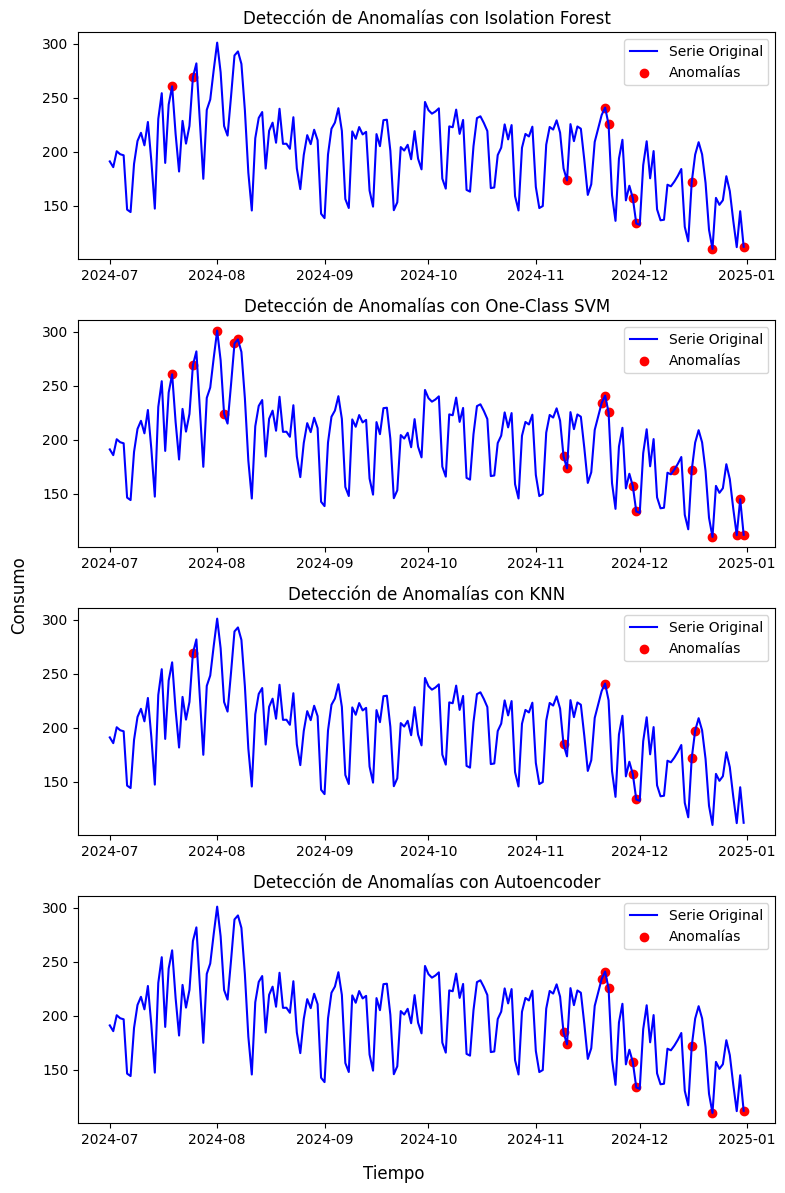

In [167]:
fig, axs = plt.subplots(4, 1, figsize=(8, 12))
i=0
for selected_model in models.keys():
    axs[i].plot(plot_df.index, plot_df["Energia Consumida"], label="Serie Original", color="blue")
    axs[i].scatter(plot_df.index[plot_df[selected_model] == 1], plot_df["Energia Consumida"][plot_df[selected_model] == 1], color='red', label='Anomalías', marker='o')
    axs[i].set_title(f"Detección de Anomalías con {selected_model}")
    axs[i].legend()
    i = i+1
# Etiquetas generales
fig.supxlabel("Tiempo")  # Etiqueta común para el eje X
fig.supylabel("Consumo")  # Etiqueta común para el eje Y
plt.tight_layout()
plt.show()

📌 Explicación:
 - Seleccionamos un modelo y graficamos las anomalías detectadas.
 - Prueba cambiando "Isolation Forest" por otro modelo para comparar.
 
---

# **Conclusión**  
 - PyOD permite probar múltiples algoritmos sin esfuerzo.
 - Cada modelo tiene diferencias en la detección de anomalías, algunos son más estrictos que otros.
 - Visualización con heatmaps facilita comparar patrones de detección.
